In [1]:
import numpy as np
import brainpy as bp
import brainpy.math as bm

bm.enable_x64()
bm.set_platform('cpu')

import matplotlib.pyplot as plt
from collections import OrderedDict


# **A Rate Model for Decision-Making**
Consider two excitatory neural assemblies, populations $1$ and $2$, that compete with each other through a shared pool of 
inhibitory neurons.

Let $r_1$ and $r_2$ be their respective population-firing rates, and the total synaptic input current $x_i$ and the resulting firing rate $r_i$ of the neural population $i$ obey the following input-output relationship ($F - I$ curve):

$$
r_i = F(x_i) = \frac{ax_i - b}{1-\exp(-d(ax_i-b))}
$$

which captures the current-frequency function of a leaky integrate-and-fire neuron. The parameter values are $a$ = 270 Hz/nA, $b$ = 108 Hz, $d$ = 0.154 sec.

Assume that the 'synaptic drive variables' $S_1$ and $S_2$ obey

\begin{align}
\frac{dS_1}{dt} &= F(x_1)\,\gamma(1-S_1)-S_1/\tau_s\\
\frac{dS_2}{dt} &= F(x_2)\,\gamma(1-S_2)-S_2/\tau_s
\end{align}

where $\gamma$ = 0.641. The net current into each population is given by 

\begin{align}
x_1 &= J_E S_1 + J_I S_2 + I_0 + I_{noise1} + J_{ext}\mu_1\\
x_2 &= J_E S_2 + J_I S_1 + I_0 + I_{noise2} +J_{ext}\mu_2.
\end{align}


The synaptic time constant is $\tau_s$ = 100 ms (NMDA time consant). The synaptic coupling strengths are $J_E$ = 0.2609 nA, $J_I$ = -0.0497 nA, and $J_{ext}$ = 0.00052 nA. Stimulus-selective inputs to populations 1 and 2 are governed by unitless parameters $\mu_1$ and $\mu_2$, respectively. $I_0+ I_{noise}$ is the background input which has a mean $I_0$ and a noise component $I_{noise}$ described by an Ornstein-Uhlenbeck process:

\begin{align}
dI_{noise1} &= - I_{noise1} \frac{dt}{\tau_0} + \sigma dW \\
dI_{noise2} &= - I_{noise2} \frac{dt}{\tau_0} + \sigma dW \\
\end{align}

where $I_0=0.3255$ nA, filter time constant $\tau_0=2$ ms, and noise amplitude $\sigma=0.02$ nA. $dW$ is a Wiener process and note that when numerially integrating that with step size $\frac{dt}{\tau_0}$ then $\Delta W \sim \mathcal{N}(0, \frac{dt}{\tau_0})$, a normal distribution with mean 0 and variance $\frac{dt}{\tau_0}$

For the decision-making paradigm, the input rates $\mu_1$ and $\mu_2$ are determined by the stimulus coherence $c'$ which ranges between 0% and 100%:

\begin{align}
\mu_1 &=\mu_0(1+c'/100)\\
\mu_2 &=\mu_0(1-c'/100)
\end{align}

**References:**

- Wong K-F and Wang X-J (2006). A recurrent network mechanism for time integration in perceptual decisions. J. Neurosci 26, 1314-1328.

In [2]:
class DecisionMakingRateModel(bp.dyn.NeuGroup):
    def __init__(self, size, coherence, JE=0.2609, JI=0.0497, Jext=5.2e-4, I0=0.3255,
                 gamma=6.41e-4, tau=100., tau_n=2., sigma_n=0.02, a=270., b=108., d=0.154,
                 noise_freq=2400., method='exp_auto', **kwargs):
        super(DecisionMakingRateModel, self).__init__(size, **kwargs)
        
        # 初始化参数
        self.coherence = coherence
        self.JE = JE
        self.JI = JI
        self.Jext = Jext
        self.I0 = I0
        self.gamma = gamma
        self.tau = tau
        self.tau_n = tau_n
        self.sigma_n = sigma_n
        self.a = a
        self.b = b
        self.d = d
        
        # 初始化变量
        self.s1 = bm.Variable(bm.zeros(self.num) + 0.15)
        self.s2 = bm.Variable(bm.zeros(self.num) + 0.15)
        self.r1 = bm.Variable(bm.zeros(self.num))
        self.r2 = bm.Variable(bm.zeros(self.num))
        self.mu0 = bm.Variable(bm.zeros(self.num))
        self.I1_noise = bm.Variable(bm.zeros(self.num))
        self.I2_noise = bm.Variable(bm.zeros(self.num))
        
        # 噪声输入的神经元
        self.noise1 = bp.dyn.PoissonGroup(self.num, freqs=noise_freq)
        self.noise2 = bp.dyn.PoissonGroup(self.num, freqs=noise_freq)
        
        # 定义积分函数
        self.integral = bp.odeint(self.derivative, method=method)
        
    @property
    def derivative(self):
        return bp.JointEq([self.ds1, self.ds2, self.dI1noise, self.dI2noise])
        
    def ds1(self, s1, t, s2, mu0):
        #### TO DO!!! S1的动力学公式
        I1 = self.Jext * mu0 * (1. + self.coherence / 100.)
        x1 = self.JE * s1 - self.JI * s2 + self.I0 + I1 + self.I1_noise
        r1 = (self.a * x1 - self.b) / (1. - bm.exp(-self.d * (self.a * x1 - self.b)))
        return - s1 / self.tau + (1. - s1) * self.gamma * r1
    
    def ds2(self, s2, t, s1, mu0):
        ### TO DO!!! S2的动力学公式
        I2=self.Jext*mu0*(1.- self.coherence / 100.)
        x2 = self.JE * s2 - self.JI * s1 + self.I0 + I2 + self.I2_noise
        r2 = (self.a * x2 - self.b) / (1. - bm.exp(-self.d * (self.a * x2 - self.b))) 
        return - s2 / self.tau + (1. - s2) * self.gamma * r2

    def dI1noise(self, I1_noise, t, noise1):
        return (- I1_noise + noise1.spike * bm.sqrt(self.tau_n * self.sigma_n * self.sigma_n)) / self.tau_n
    
    def dI2noise(self, I2_noise, t, noise2):
        return (- I2_noise + noise2.spike * bm.sqrt(self.tau_n * self.sigma_n * self.sigma_n)) / self.tau_n
    
    
    def update(self, tdi):
        # 更新噪声神经元以产生新的随机发放 self.noise1.update(tdi) self.noise2.update(tdi)
        # 更新s1、s2、I1_noise、I2_noise
        integral = self.integral(self.s1, self.s2, self.I1_noise, self.I2_noise, tdi.t, mu0=self.mu0,
                             noise1=self.noise1, noise2=self.noise2, dt=tdi.dt)
        self.s1.value, self.s2.value, self.I1_noise.value, self.I2_noise.value = integral
        
        # 用更新后的s1、s2计算r1、r2
        #### TO DO!!!
        I1 = self.Jext * self.mu0 * (1. + self.coherence / 100.)
        x1 = self.JE * self.s1 + self.JI * self.s2 + self.I0 + I1 + self.I1_noise
        self.r1.value = (self.a * x1 - self.b) / (1. - bm.exp(-self.d * (self.a * x1 - self.b)))
        I2 = self.Jext * self.mu0 * (1. - self.coherence / 100.)
        x2 = self.JE * self.s2 + self.JI * self.s1 + self.I0 + I2 + self.I2_noise
        self.r2.value = (self.a * x2 - self.b) / (1. - bm.exp(-self.d * (self.a * x2 - self.b)))
        
        # 重置外部输入 
        self.mu0[:] = 0.

  0%|          | 0/26000 [00:00<?, ?it/s]

/Users/liuxiao/anaconda3/envs/brainpy/lib/python3.11/site-packages/brainpy/_src/dynsys.py:305: UserWarning: 
From brainpy>=2.4.3, update() function no longer needs to receive a global shared argument.

Instead of using:

  def update(self, tdi, *args, **kwagrs):
     t = tdi['t']
     ...

Please use:

  def update(self, *args, **kwagrs):
     t = bp.share['t']
     ...

  warnings.warn(_update_deprecate_msg, UserWarning)


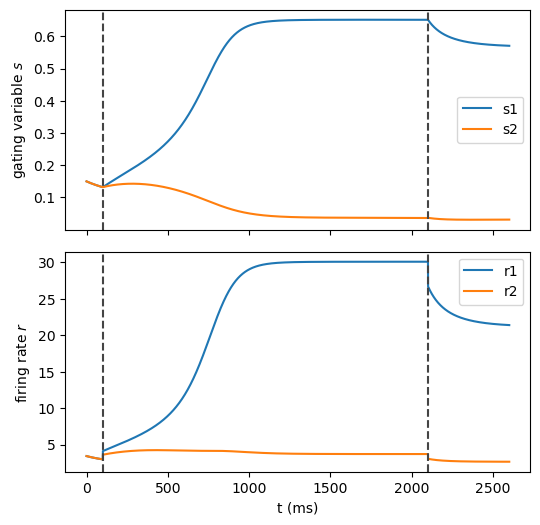

In [3]:
# 定义各个阶段的时长
pre_stimulus_period, stimulus_period, delay_period = 100., 2000., 500.

# 生成模型
dmnet = DecisionMakingRateModel(1, coherence=25.6, noise_freq=2400.)

# 定义电流随时间的变化
inputs, total_period = bp.inputs.constant_input([(0., pre_stimulus_period),
                                                 (20., stimulus_period),
                                                 (0., delay_period)])
# 运行数值模拟
runner = bp.DSRunner(dmnet,
                     monitors=['s1', 's2', 'r1', 'r2'],
                     inputs=('mu0', inputs, 'iter'))
runner.run(total_period)

# 可视化
fig, gs = plt.subplots(2, 1, figsize=(6, 6), sharex='all')
gs[0].plot(runner.mon.ts, runner.mon.s1, label='s1')
gs[0].plot(runner.mon.ts, runner.mon.s2, label='s2')
gs[0].axvline(pre_stimulus_period, 0., 1., linestyle='dashed', color=u'#444444')
gs[0].axvline(pre_stimulus_period + stimulus_period, 0., 1., linestyle='dashed', color=u'#444444')
gs[0].set_ylabel('gating variable $s$')
gs[0].legend()

gs[1].plot(runner.mon.ts, runner.mon.r1, label='r1')
gs[1].plot(runner.mon.ts, runner.mon.r2, label='r2')
gs[1].axvline(pre_stimulus_period, 0., 1., linestyle='dashed', color=u'#444444')
gs[1].axvline(pre_stimulus_period + stimulus_period, 0., 1., linestyle='dashed', color=u'#444444')
gs[1].set_xlabel('t (ms)')
gs[1].set_ylabel('firing rate $r$')
gs[1].legend()

plt.subplots_adjust(hspace=0.1)
plt.show()


  0%|          | 0/26000 [00:00<?, ?it/s]

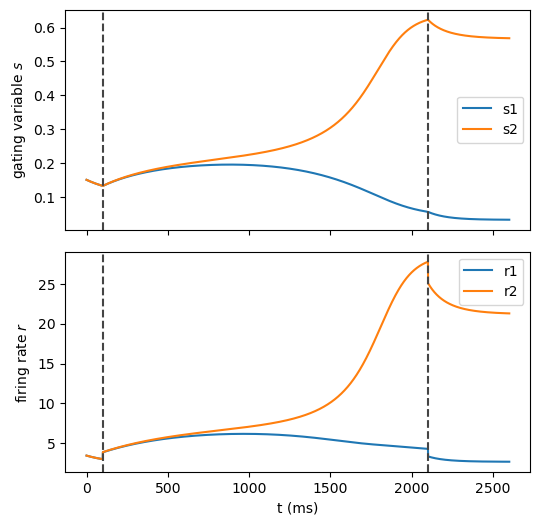

In [4]:
# 生成模型
dmnet = DecisionMakingRateModel(1, coherence=-1, noise_freq=2400.)

# 定义电流随时间的变化
inputs, total_period = bp.inputs.constant_input([(0., pre_stimulus_period),
                                                 (20., stimulus_period),
                                                 (0., delay_period)])
# 运行数值模拟
runner = bp.DSRunner(dmnet,
                     monitors=['s1', 's2', 'r1', 'r2'],
                     inputs=('mu0', inputs, 'iter'))
runner.run(total_period)

# 可视化
fig, gs = plt.subplots(2, 1, figsize=(6, 6), sharex='all')
gs[0].plot(runner.mon.ts, runner.mon.s1, label='s1')
gs[0].plot(runner.mon.ts, runner.mon.s2, label='s2')
gs[0].axvline(pre_stimulus_period, 0., 1., linestyle='dashed', color=u'#444444')
gs[0].axvline(pre_stimulus_period + stimulus_period, 0., 1., linestyle='dashed', color=u'#444444')
gs[0].set_ylabel('gating variable $s$')
gs[0].legend()

gs[1].plot(runner.mon.ts, runner.mon.r1, label='r1')
gs[1].plot(runner.mon.ts, runner.mon.r2, label='r2')
gs[1].axvline(pre_stimulus_period, 0., 1., linestyle='dashed', color=u'#444444')
gs[1].axvline(pre_stimulus_period + stimulus_period, 0., 1., linestyle='dashed', color=u'#444444')
gs[1].set_xlabel('t (ms)')
gs[1].set_ylabel('firing rate $r$')
gs[1].legend()

plt.subplots_adjust(hspace=0.1)
plt.show()


## Phase plane analysis

### Parameters:

In [5]:
gamma = 0.641  # Saturation factor for gating variable
tau = 0.1  # Synaptic time constant [sec]
a = 270.  #  Hz/nA
b = 108.  # Hz
d = 0.154  # sec

JE = 0.2609  # self-coupling strength [nA]
JI = -0.0497  # cross-coupling strength [nA]
JAext = 0.00052  # Stimulus input strength [nA]
Ib = 0.3255  # The background input Ib=I0+I_noise

### Model implementation

$$
r_i = F(x_i) = \frac{ax_i - b}{1-\exp(-d(ax_i-b))}
$$

\begin{align}
\frac{dS_1}{dt} &= F(x_1)\,\gamma(1-S_1)-S_1/\tau_s\\
\frac{dS_2}{dt} &= F(x_2)\,\gamma(1-S_2)-S_2/\tau_s
\end{align}


\begin{align}
x_1 &= J_E S_1 + J_I S_2 + I_0 + I_{noise1} + J_{ext}\mu_1\\
x_2 &= J_E S_2 + J_I S_1 + I_0 + I_{noise2} +J_{ext}\mu_2.
\end{align}



In [6]:
@bp.odeint
def int_s1(s1, t, s2, coh=0.5, mu=20.):
    x1 = JE * s1 + JI * s2 + Ib + JAext * mu * (1. + coh/100)
    r1 = (a * x1 - b) / (1. - bm.exp(-d * (a * x1 - b)))
    return - s1 / tau + (1. - s1) * gamma * r1

@bp.odeint
def int_s2(s2, t, s1, coh=0.5, mu=20.):
    #### TO DO!!!S2的动力学表达式
    x2 = JE * s2 + JI * s1 + Ib + JAext * mu * (1. - coh/100)
    r2 = (a * x2 - b) / (1. - bm.exp(-d * (a * x2 - b)))
    return - s2 / tau + (1. - s2) * gamma * r2

No stimulus: $μ_0=0$ Hz.

I am creating the vector field ...
I am computing fx-nullcline ...
I am evaluating fx-nullcline by optimization ...
I am computing fy-nullcline ...
I am evaluating fy-nullcline by optimization ...
I am searching fixed points ...
I am trying to find fixed points by optimization ...
	There are 1212 candidates
I am trying to filter out duplicate fixed points ...
	Found 5 fixed points.
	#1 s1=0.5669871605297275, s2=0.03189141971571579 is a stable node.
	#2 s1=0.3138449248913598, s2=0.05578533347184556 is a saddle node.
	#3 s1=0.10265144582202228, s2=0.10265095098913339 is a stable node.
	#4 s1=0.05578534267632876, s2=0.3138449310808803 is a saddle node.
	#5 s1=0.03189144636489119, s2=0.5669870352865433 is a stable node.


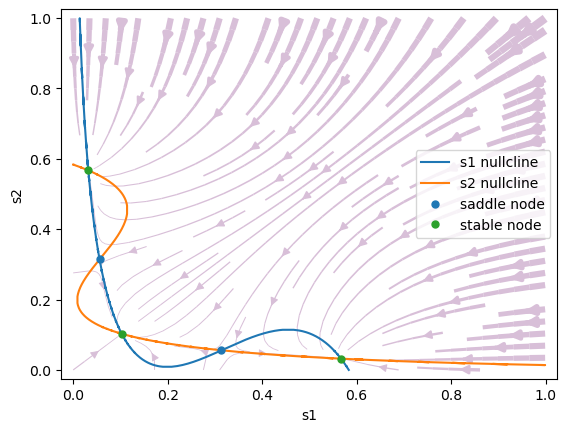

In [7]:
##### TO DO!!! mu=0 的情况
analyzer = bp.analysis.PhasePlane2D(
    model=[int_s1, int_s2],
    target_vars={'s1': [0, 1], 's2': [0, 1]},
    pars_update={'mu': 0.},
    resolutions=0.001,
)

analyzer.plot_vector_field()
analyzer.plot_nullcline(coords=dict(s2='s2-s1'),
                        x_style={'fmt': '-'},
                        y_style={'fmt': '-'})
analyzer.plot_fixed_point()
analyzer.show_figure()

Symmetric stimulus: 
$μ_0=30 Hz, c'=0.$ 

I am creating the vector field ...
I am computing fx-nullcline ...
I am evaluating fx-nullcline by optimization ...
I am computing fy-nullcline ...
I am evaluating fy-nullcline by optimization ...
I am searching fixed points ...
I am trying to find fixed points by optimization ...
	There are 1212 candidates
I am trying to filter out duplicate fixed points ...
	Found 3 fixed points.
	#1 s1=0.658694232143127, s2=0.051807199439912924 is a stable node.
	#2 s1=0.4244557898485831, s2=0.42445562837314016 is a saddle node.
	#3 s1=0.05180717720080604, s2=0.6586942355713474 is a stable node.


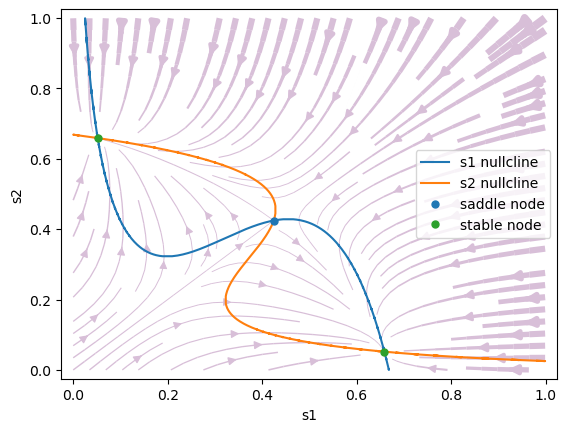

In [8]:
##### TO DO!!! mu=30 coh=0的情况
analyzer = bp.analysis.PhasePlane2D(
    model=[int_s1, int_s2],
    target_vars={'s1': [0, 1], 's2': [0, 1]},
    pars_update={'mu': 30., 'coh': 0.},
    resolutions=0.001,
)
analyzer.plot_vector_field()
analyzer.plot_nullcline(coords=dict(s2='s2-s1'),
                        x_style={'fmt': '-'},
                        y_style={'fmt': '-'})
analyzer.plot_fixed_point()
analyzer.show_figure()

Symmetric stimulus: 
$μ_0=30 Hz, c'=14\%$ 

I am creating the vector field ...
I am computing fx-nullcline ...
I am evaluating fx-nullcline by optimization ...
I am computing fy-nullcline ...
I am evaluating fy-nullcline by optimization ...
I am searching fixed points ...
I am trying to find fixed points by optimization ...
	There are 1212 candidates
I am trying to filter out duplicate fixed points ...
	Found 3 fixed points.
	#1 s1=0.6679776124172938, s2=0.045830222261007005 is a stable node.
	#2 s1=0.38455860789855545, s2=0.45363090352898194 is a saddle node.
	#3 s1=0.05911003280235089, s2=0.6481046659437737 is a stable node.


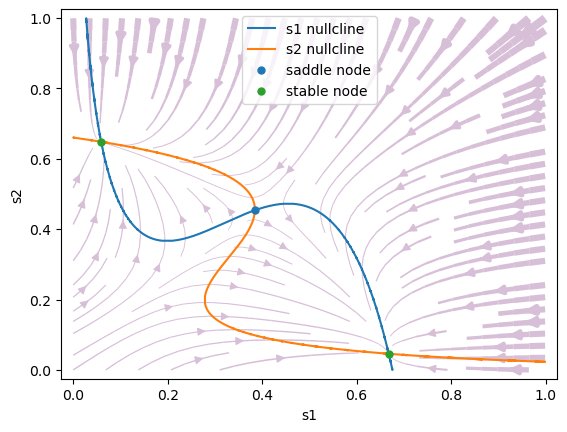

In [9]:
##### TO DO!!! mu=30 coh=14的情况
analyzer = bp.analysis.PhasePlane2D(
    model=[int_s1, int_s2],
    target_vars={'s1': [0, 1], 's2': [0, 1]},
    pars_update={'mu': 30., 'coh': 14.},
    resolutions=0.001,
)
analyzer.plot_vector_field()
analyzer.plot_nullcline(coords=dict(s2='s2-s1'),
                        x_style={'fmt': '-'},
                        y_style={'fmt': '-'})
analyzer.plot_fixed_point()
analyzer.show_figure()

Symmetric stimulus: 
$μ_0=30 Hz, c'=100\%$ 

I am creating the vector field ...
I am computing fx-nullcline ...
I am evaluating fx-nullcline by optimization ...
I am computing fy-nullcline ...
I am evaluating fy-nullcline by optimization ...
I am searching fixed points ...
I am trying to find fixed points by optimization ...
	There are 1212 candidates
I am trying to filter out duplicate fixed points ...
	Found 1 fixed points.
	#1 s1=0.7092805209334905, s2=0.0239636630419946 is a stable node.


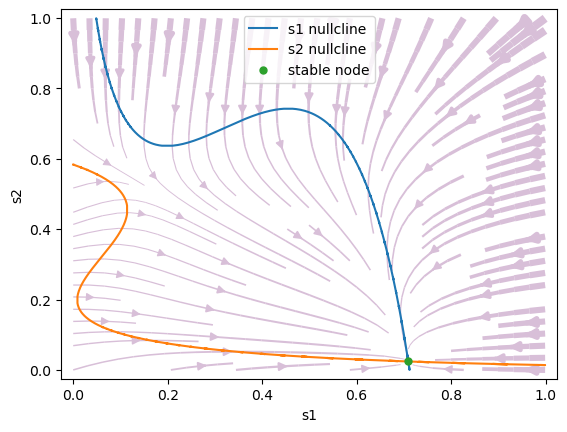

In [10]:
##### TO DO!!! mu=30 coh=100的情况
analyzer = bp.analysis.PhasePlane2D(
    model=[int_s1, int_s2],
    target_vars={'s1': [0, 1], 's2': [0, 1]},
    pars_update={'mu': 30., 'coh': 100.},
    resolutions=0.001,
)
analyzer.plot_vector_field()
analyzer.plot_nullcline(coords=dict(s2='s2-s1'),
                        x_style={'fmt': '-'},
                        y_style={'fmt': '-'})
analyzer.plot_fixed_point()
analyzer.show_figure()